>># **Final Project - Document Corner Detection out of ICDAR 2015 Dataset**

>>Yoel Bokobza ID: 312190481.

>>Shahaf Yamin ID: 311530943.

# Introduction

Documents exist in both paper and digital form in our everyday life. Paper documents are easier to carry, read, and share whereas digital documents are easier to search, index, and store. For efficient knowledge management, it is often required to convert a paper document to digital format. 

Document segmentation from the background is one of the major challenges of digitization from a natural image. An image of a document often contains the surface on which the document was placed to take the picture. It can also contain other non-document objects in the frame. Precise localization of document, often called document segmentation, from such an image is an essential first step required for digitization. Some of the challenges involved in localization are variations in document and background types, perspective distortions, shadows, and other objects in the image.

# Dataset

’ICDAR 2015 SmartDoc Challenge 1’ dataset is used for training and testing. The dataset contains 150 videos. Each video is around 10 seconds long and contains one of the six types of documents placed on one of the five distinct backgrounds. We split these videos into two disjoint sets.
Ground truth is available in the form of (x,y) coordinates labels:
top left (tl), top right (tr), bottom right (br), and bottom left (bl).

The short videos are taken over 5 different backgrounds, where background 5 is relatively complex as will be shown later.
Over each background, the videos have been taken over different document types - datasheet, letter, magazine, paper, patent, and tax, (5 short videos per background and document type).

As an initial pre-process, we replaced each video with its frames (resolution of 1920X1080).
The following images are random frames taken from different videos:




##Background 01 - Datasheet Document
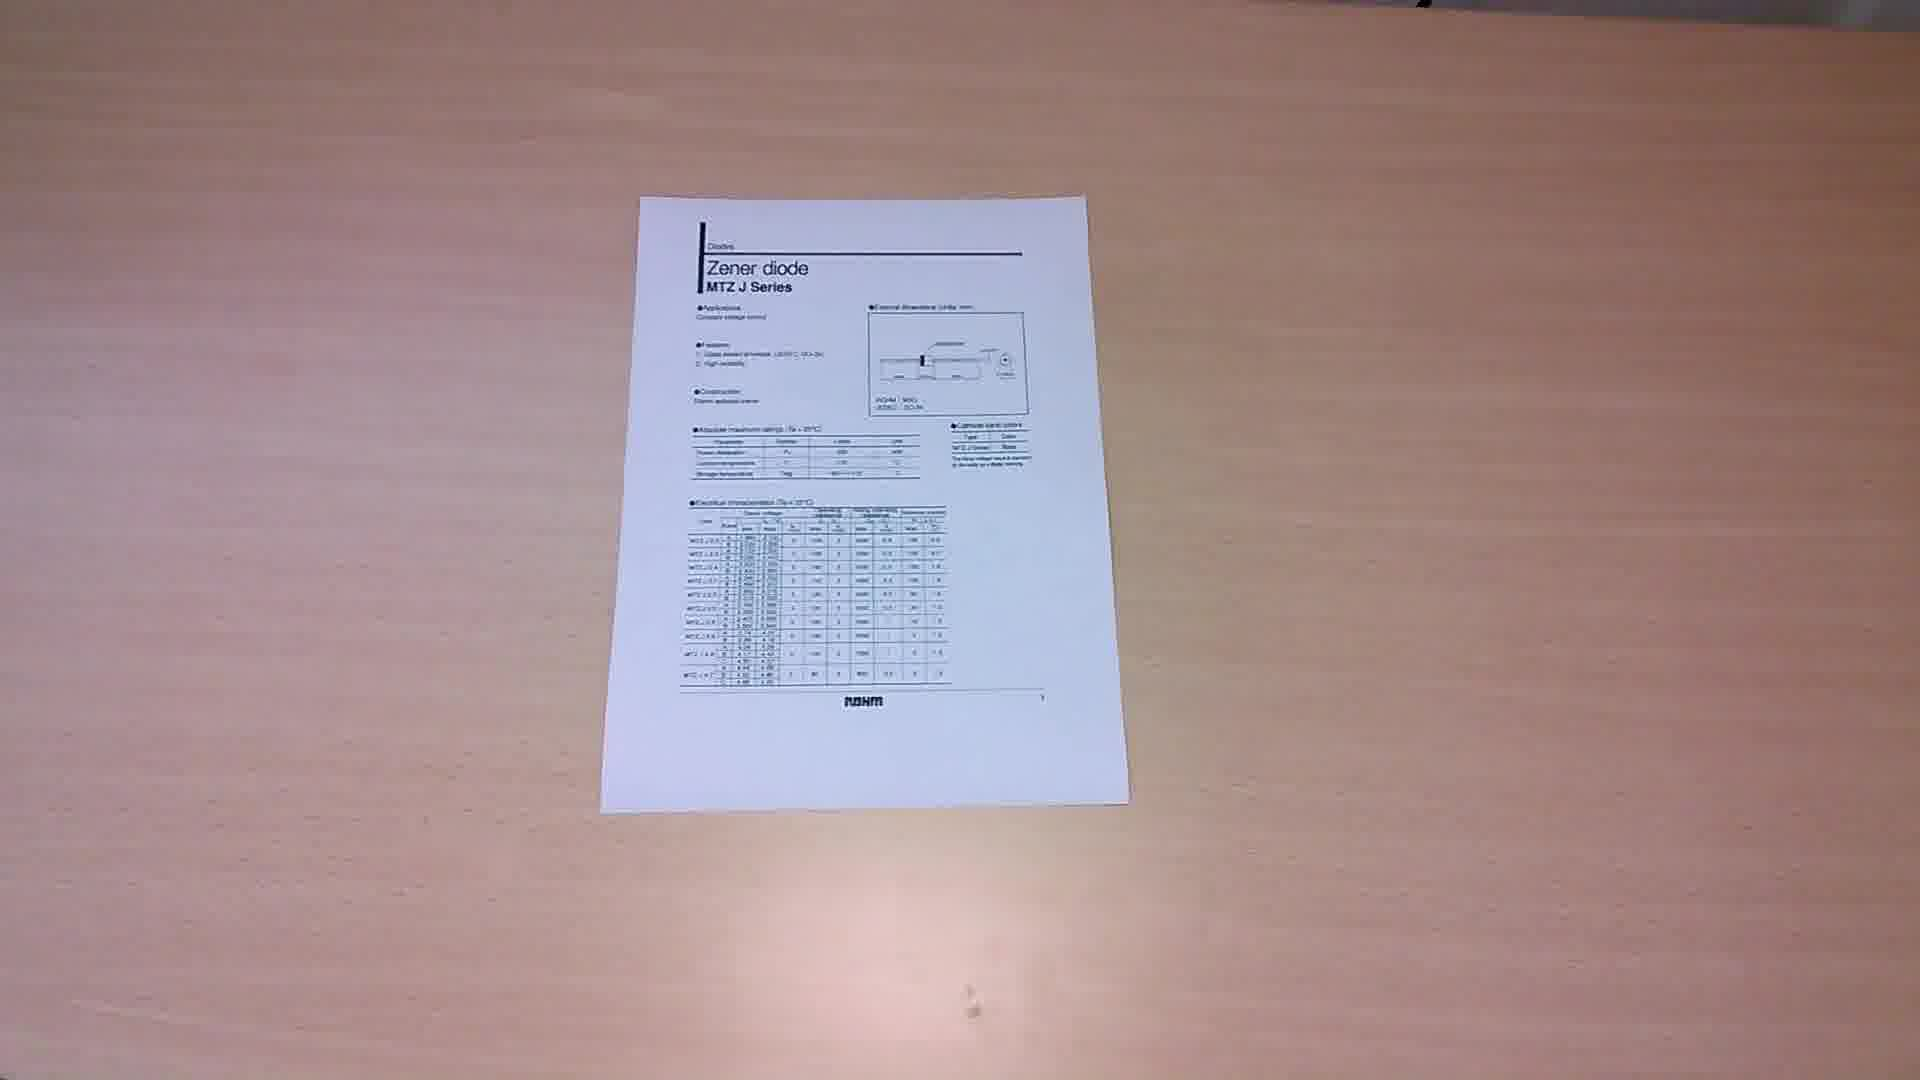



## Background 02 - Magazine Document
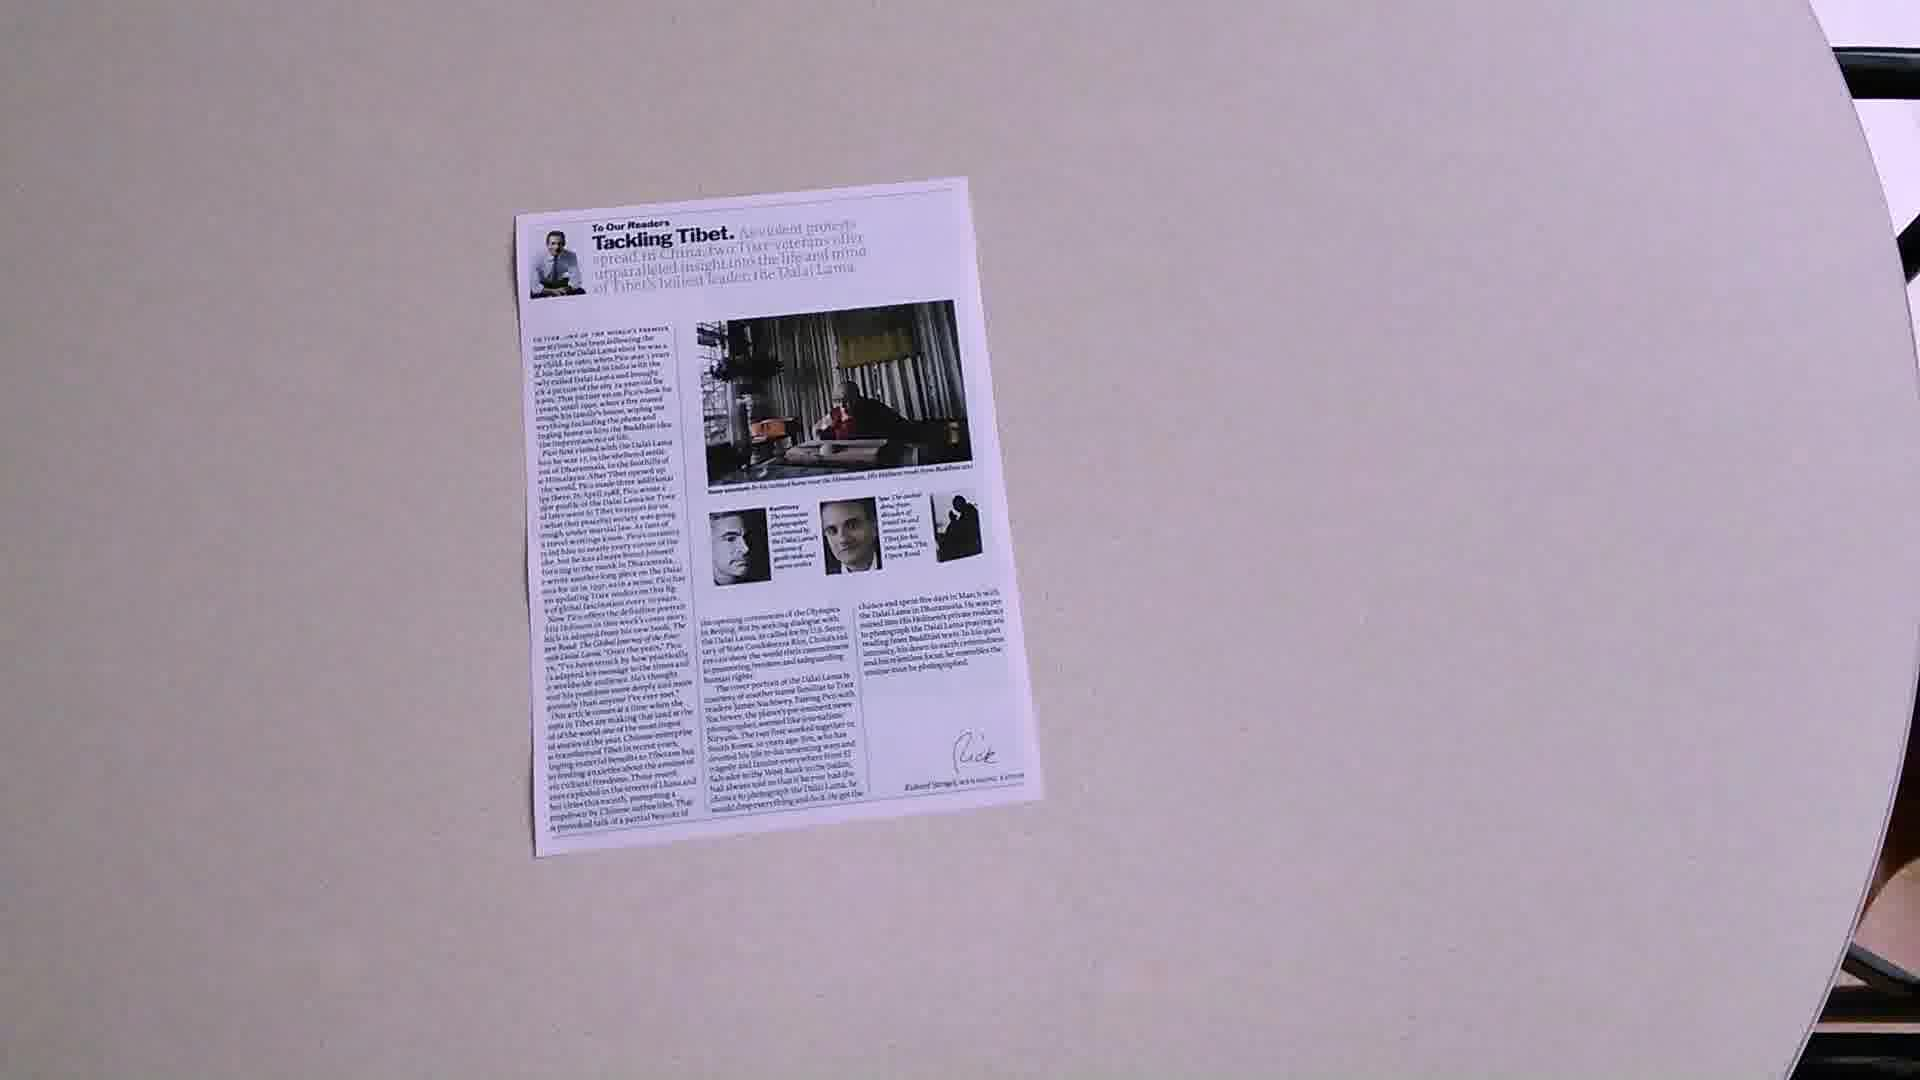


## Background 03 - Patent Document
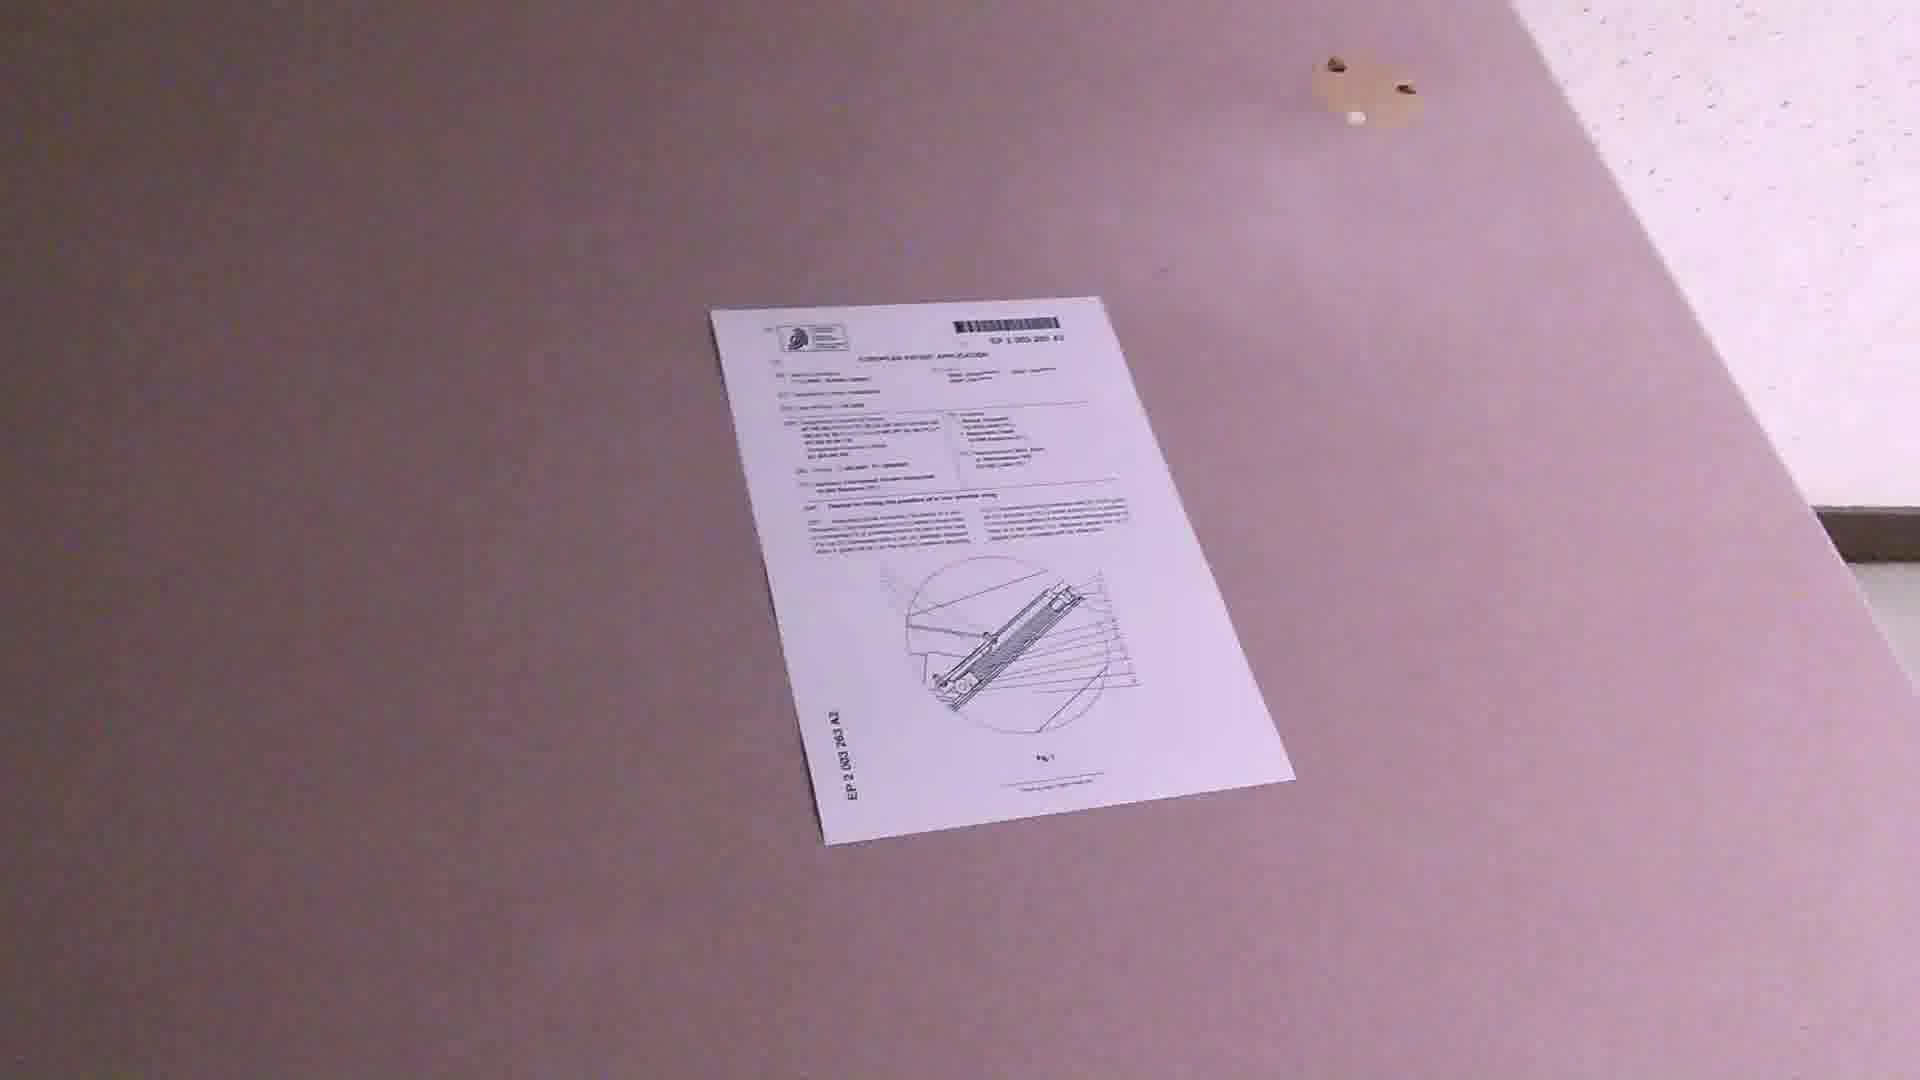


## Background 04 - Letter Document
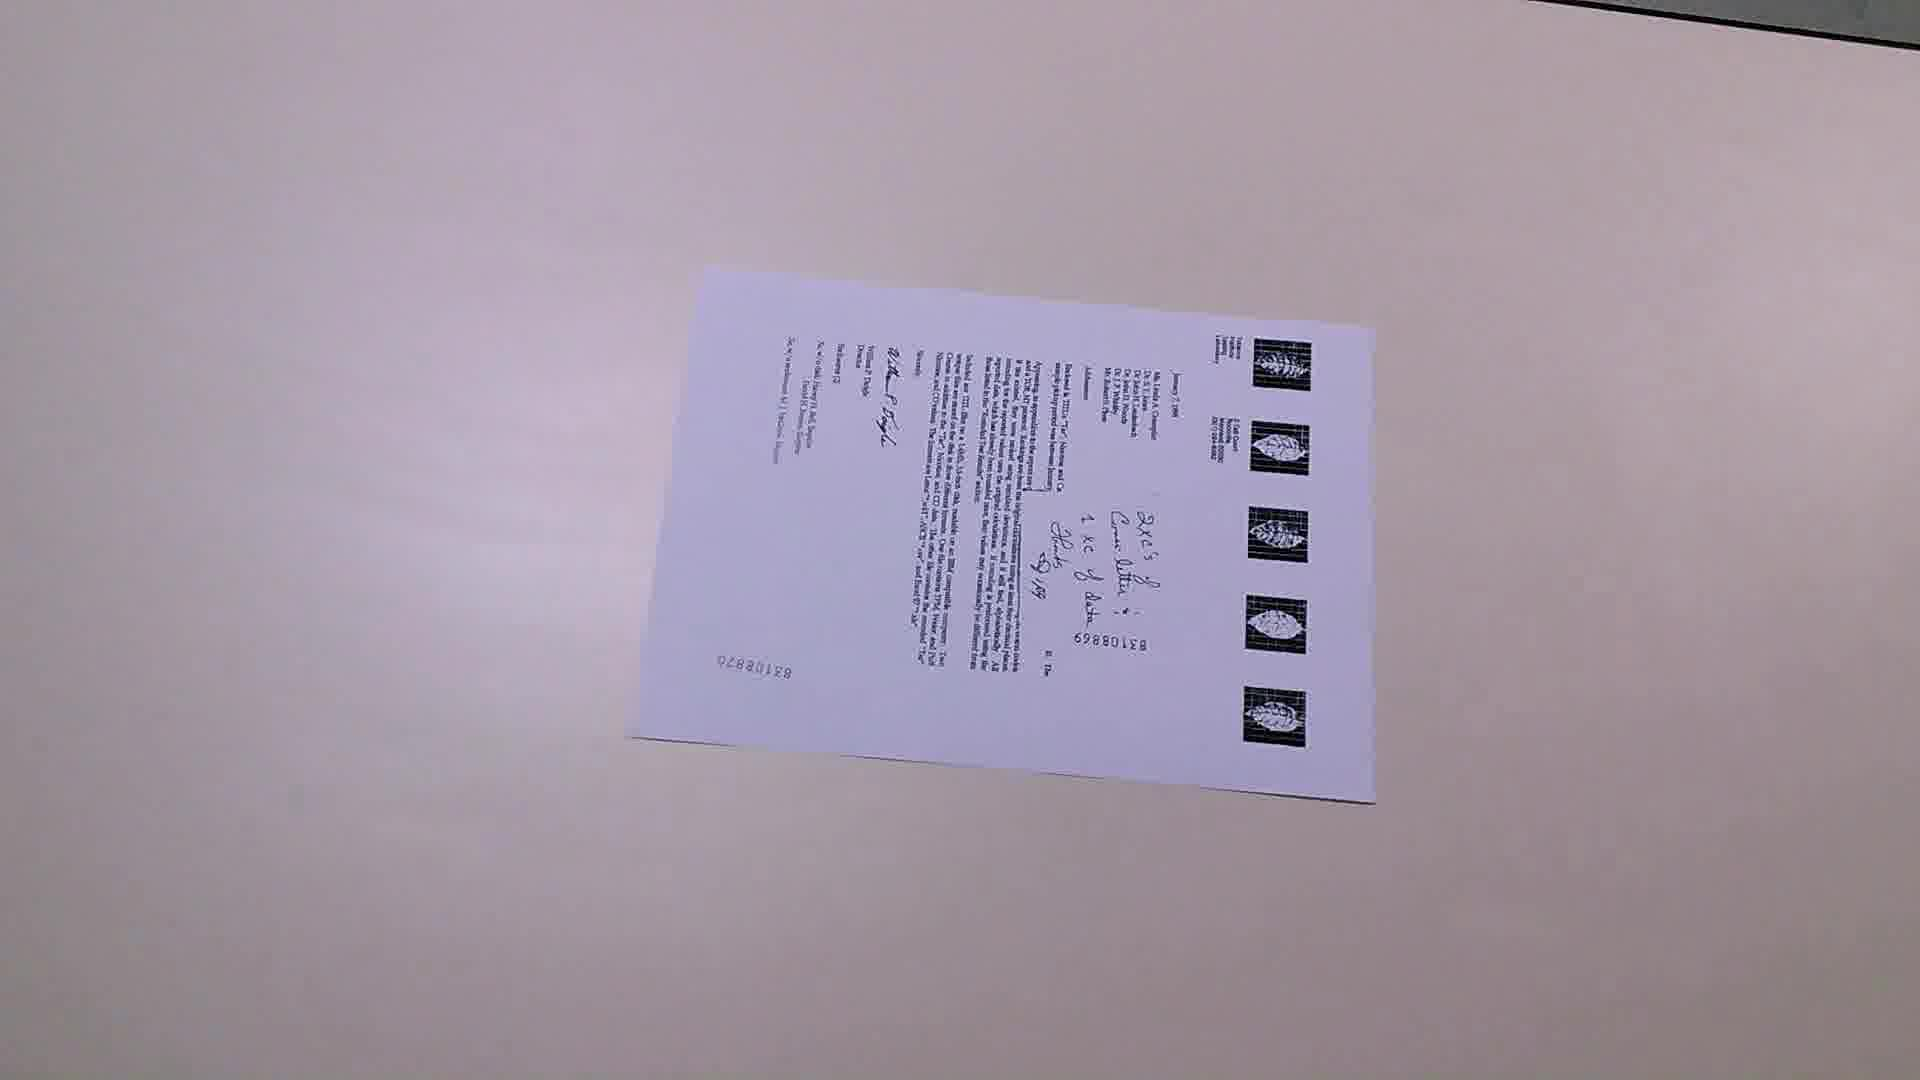

## Background 05 - Paper Document 
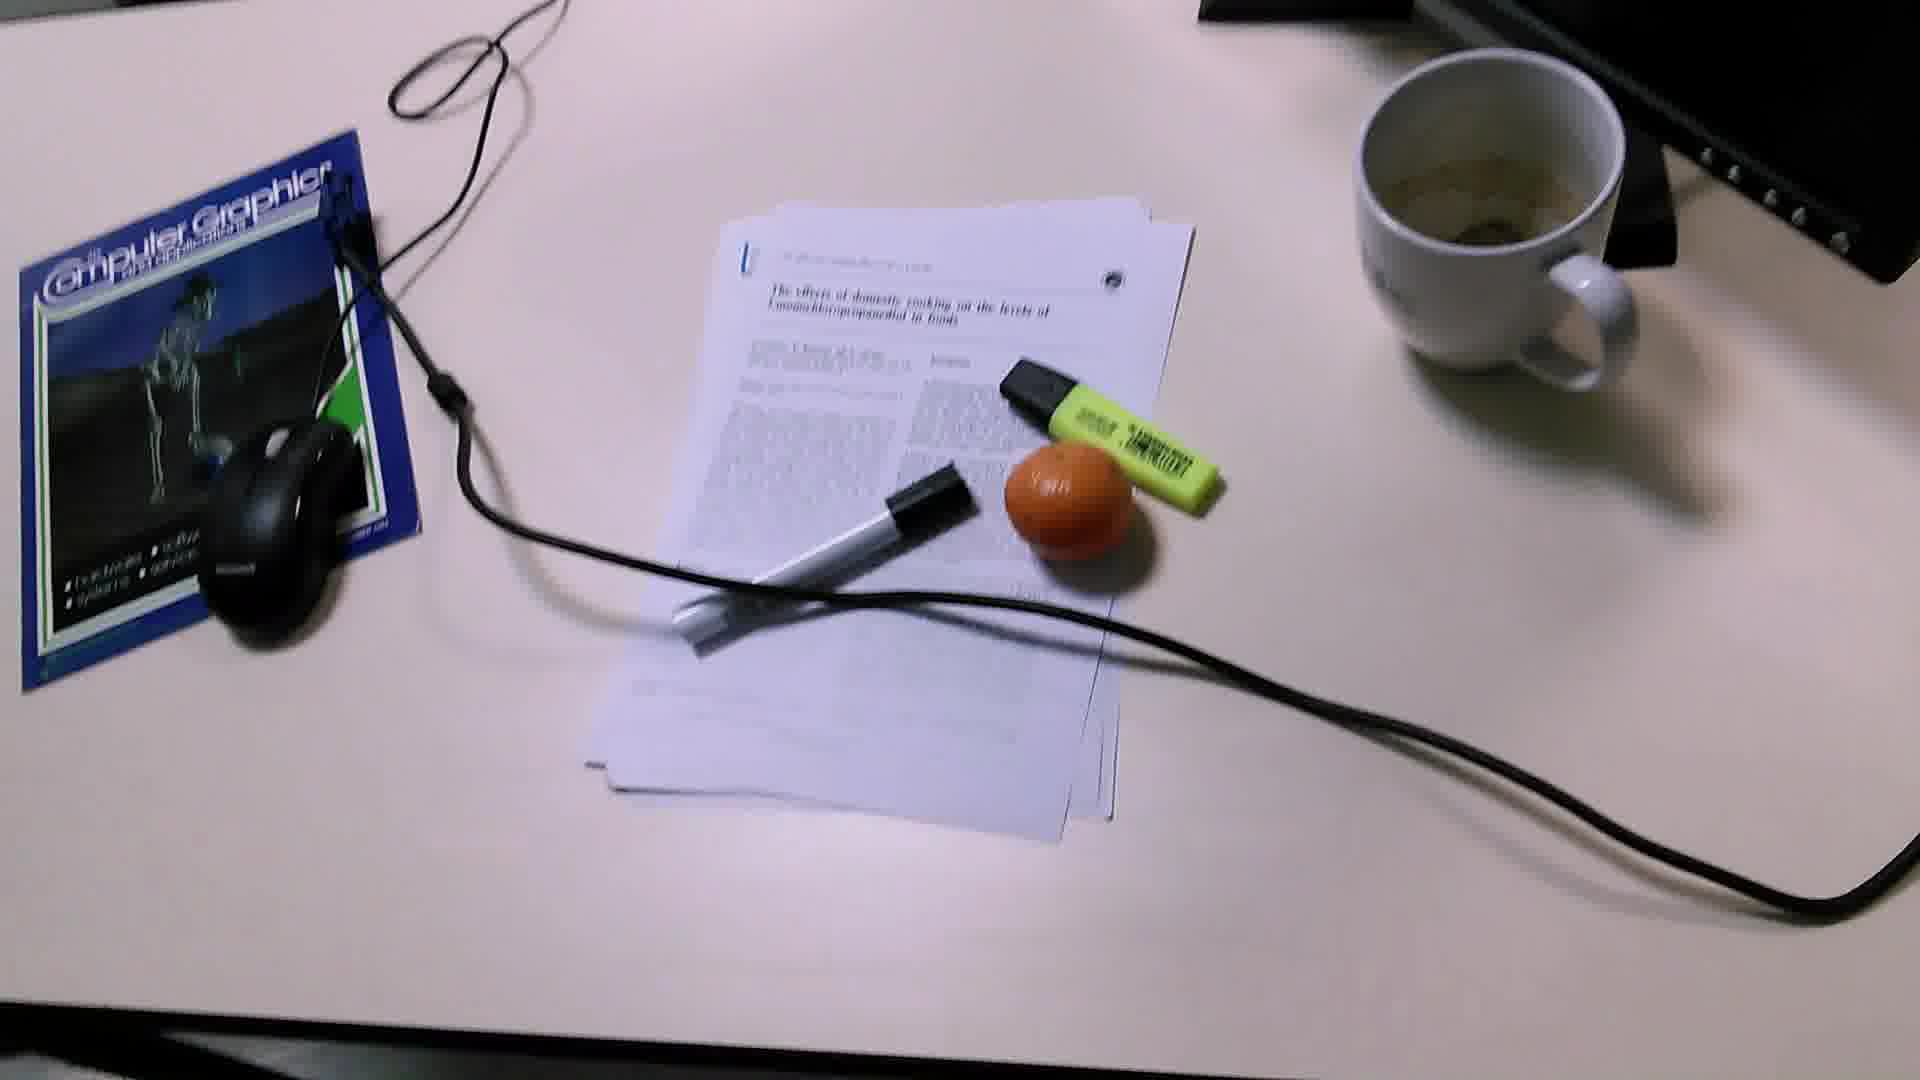

# Our Goal

The goal is to design an algorithm that gets as input an image of the document and predicts the tl, tr, bl, br coordinates of the document.

It is expected that the algorithm will run in a reasonable time (a few seconds).

#Limitations

*  A batch of images with a high resolution (1920x1080) requires a substantial amount of RAM, making them difficult to use as inputs for neural networks on a standard GPU server. We addresed this problem by applying the following paradigm: Applying a 512x512 resize, results in a reduction in computational complexity. 
In addition, we've run our experiments on GPU servers with more available RAM and computing power to accelerate the training procedure.
*   The data set is large. Hence, it is computationally hard to use even 50 percent of the data for training. Therefore, we sampled randomly 50 frames from each video (except for the tax document videos) for the training.
* Reducing the dataset size by randomly sampling frames from each video and shuffling the sampled dataset, also addresses the issue that consecutive frames from each video are highly correlated which violates the i.i.d assumption of the dataset.
* Frames from background 05 are relatively complex compared with the other backgrounds because it contains other objects in the frame placed near or on top of the document.
* The Dataset used to train the benchmark (from the Git) does not contain a validation set. (Only training and test)



#Proposed Algorithm

## High Level Description

We can divide this proposed algorithm into 4 main units:

### Preprocess
1.   Split the data into train, and test
2.   Resize the images to 512X512
3.   Normalize the dataset according to the train set mean and standard deviation.
4.   Apply a Gaussian filter over the images.

### Document Segmentation
Using the well-known deep learning architecture U-Net [1] to create a binary mask segmentation of the document.

### Extracting Corners
The following steps details the algorithm we've developed to extract the 4 corners estimation coordinates from the masked image:
1. Extract edges from the masked image
2.   Apply Hough transform [2] over the edged masked image and extract some predefined number of peaks.
3.   Apply a hand-crafted clustering method to find an estimation of the 4 lines constructing the quadrilateral shape of the masked image
4. Extract corners from the lines equations

### Corners Estimation Refiner
We utilized the edged masked image to further improve the corners estimation.



## Block Diagram

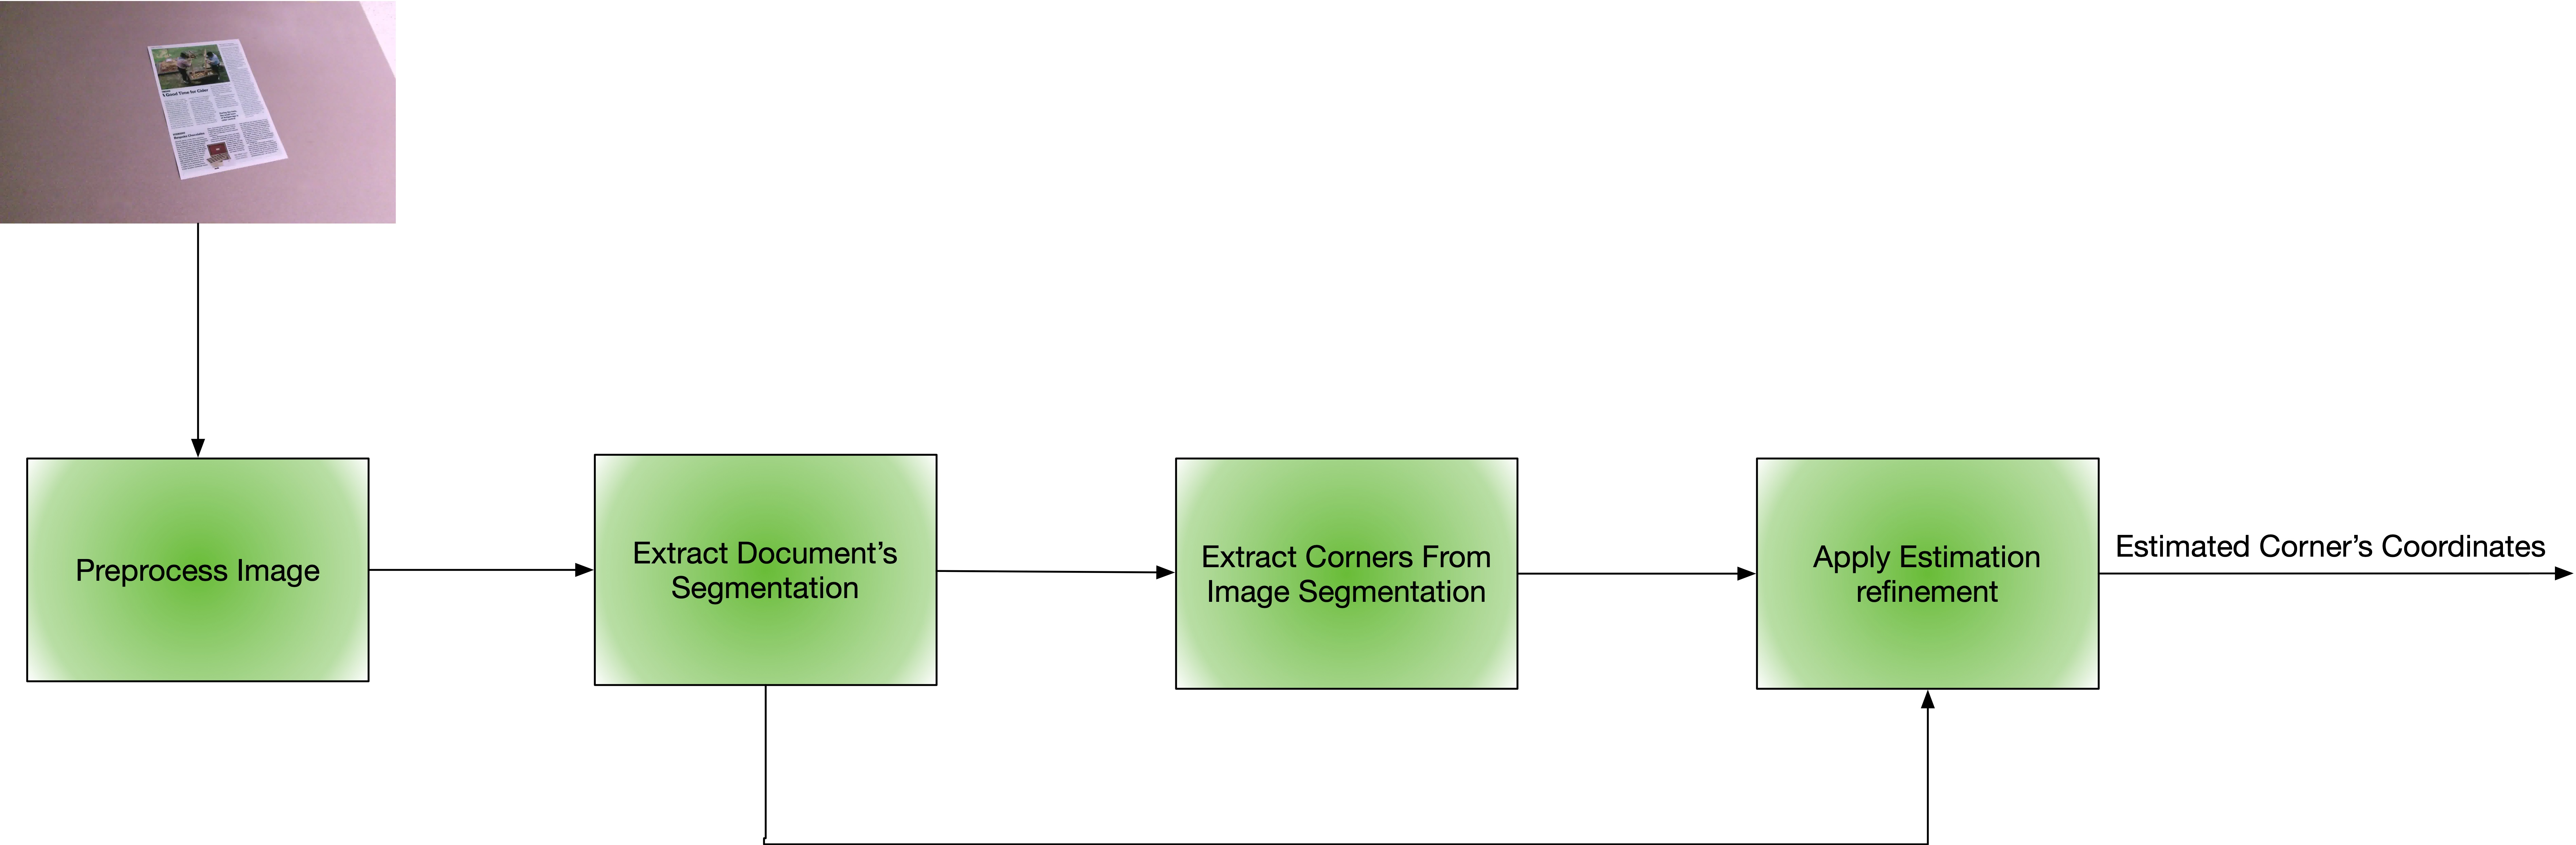

Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


**Before Running the following blocks, please copy the shared folder "DeepLearningProject" into your "MyDrive", or just create a shortcut, by right-clicking on the shared folder and then, "create a shortcut in Drive")**

## Import Libraries

In [ ]:
import os                                   
from os.path import abspath
from PIL import Image                        
import PIL.Image as Image
from skimage import transform
import torch  
torch.manual_seed(0)
import torch.optim as optim            
import torch.nn as nn                        
import torch.nn.functional as F          
from torch.utils.data import Dataset      
from torch.utils.data import DataLoader
import numpy as np   
np.random.seed(0)                       
import random
random.seed(10)
import cv2          
import xml.etree.ElementTree as ET                         
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage, GaussianBlur, Compose
import torchvision.transforms.functional as TF
from tqdm import tqdm                         
import matplotlib.pyplot as plt                 
from matplotlib.path import Path
from torch import Tensor
from torch.nn import init
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import math
from copy import deepcopy
import numbers

device = torch.device('cpu')

## Preprocess

### Utils for Data Prepration
The following code block contains utils for our data preprocessing procedure.

In [ ]:
def sort_predication(masks_pred):
    """
    The following function receives our corner estimation and sort it according to a predefined sequence
    [Top Left, Top Right, Bottom Right, Bottom Left]
    """
    sort_idx = np.argsort(masks_pred[:, 0])
    tl_idx = np.argmin(masks_pred[sort_idx][:2][:, 1])
    tr_idx = np.argmax(masks_pred[sort_idx][:2][:, 1])
    tl = masks_pred[sort_idx][:2][tl_idx]
    tr = masks_pred[sort_idx][:2][tr_idx]
    bl_idx = np.argmin(masks_pred[sort_idx][2:][:, 1])
    br_idx = np.argmax(masks_pred[sort_idx][2:][:, 1])
    bl = masks_pred[sort_idx][2:][bl_idx]
    br = masks_pred[sort_idx][2:][br_idx]
    return np.array([tl, tr, br, bl])

def gen_mask(coordinates, sizeX, sizeY, sort):
    '''
    The following function generates a binary mask image given 4 2-dimensional coordinates.
    '''


    nx, ny = sizeX, sizeY
    if sort:
        coordinates = sort_predication(coordinates)
        coordinates = list(map(tuple, coordinates))

    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    coordinates.append((0., 0.))
    poly_verts = coordinates
    # Create vertex coordinates for each grid cell...
    # (<0,0> is at the top left of the grid in this system)
    y, x = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()

    points = np.vstack((x, y)).T

    path = Path(poly_verts, codes=codes)
    grid = path.contains_points(points)
    mask = grid.reshape((ny, nx)).T
    return mask

def sort_gt(gt):
    '''
    Sort the ground truth labels so that TL corresponds to the label with smallest distance from O
    :param gt:
    :return: sorted gt
    '''
    myGtTemp = gt * gt
    sum_array = myGtTemp.sum(axis=1)
    tl_index = np.argmin(sum_array)
    tl = gt[tl_index]
    tr = gt[(tl_index + 1) % 4]
    br = gt[(tl_index + 2) % 4]
    bl = gt[(tl_index + 3) % 4]

    return np.asarray((tl, tr, br, bl))


### Load the data and organize it
The following classes load the raw data and organize it.
It also generates the ground truth binary masks from the corresponded ground truth corners. In addition, it is able to calculate first and second-order statistical moments from a given dataset in order to normalize the data.


In [ ]:
class _Dataset():
    '''
    Base class to reprenent a Dataset
    '''
    def __init__(self, name):
        self.name = name
        self.data = []
        self.labels = []

class SmartDocDirectories(_Dataset):
    '''
    Class to include SmartDoc Dataset via full resolution images while sampling only 2 images from a single video
    '''

    def __init__(self, frames_per_video, directory="data"):
        super().__init__("smartdoc")
        self.data = []
        self.labels = []

        for folder in os.listdir(directory):
            if (os.path.isdir(directory + "/" + folder)):
                if os.path.isdir(directory+"/"+folder+"/"+os.listdir(directory + "/" + folder)[0]):
                    for file in os.listdir(directory + "/" + folder):
                        images_dir = directory + "/" + folder + "/" + file
                        self.read_background(images_dir,frames_per_video, file=file)                
                else:
                    images_dir = directory + "/" + folder
                    self.read_background(images_dir, frames_per_video, file=folder)


        self.labels = np.array(self.labels)

        self.labels = np.reshape(self.labels, (-1, 8))
        print("Ground Truth Shape: %s", str(self.labels.shape))
        print("Data shape %s", str(len(self.data)))

        self.myData = []
        for a in range(len(self.data)):
            self.myData.append([self.data[a], self.labels[a]])

    def read_background(self, images_dir, frames_per_video, file):

        if (os.path.isdir(images_dir)):
          list_gt = []
          tree = ET.parse(images_dir + "/" + file + ".gt")
          root = tree.getroot()
          for a in root.iter("frame"):
              list_gt.append(a)

          im_no = 0
          # List all available images in a list
          images_list = os.listdir(images_dir)
          # Remove from the list the Ground True
          images_list.remove(file + ".gt")
          
          if frames_per_video == 'all':
            ChosenImages = list(images_list)
          else:
            ChosenImages = list(np.random.choice(images_list, size=frames_per_video))
          for image in ChosenImages:
              im_no += 1
              # Now we have opened the file and GT. Write code to create multiple files and scale gt
              list_of_points = {}

              self.data.append(os.path.join(images_dir, image))
              imageIndex = int(float(image[0:-4])) - 1
              for point in list_gt[imageIndex].iter("point"):
                  myDict = point.attrib

                  list_of_points[myDict["name"]] = (int(float(myDict['x'])), int(float(myDict['y'])))

              ground_truth = np.asarray((list_of_points["tl"], list_of_points["tr"], list_of_points["br"], list_of_points["bl"]))
              ground_truth = sort_gt(ground_truth)
              self.labels.append(ground_truth)


def generate_full_resolution_partial_dataset(path,frames_per_video, size):
    '''
    This function generate a dataset from a given path of images and sample a predefined number of random frames from each video.
    Our dataset contain 3 main objects.
    - Raw RGB Images.
    - Ground Truth Binary Masks.
    - Ground Truth Corners Coordinates.
    It also calculates the first and second statisticals moments of the given dataset.
    '''
    dataset = SmartDocDirectories(directory=path, frames_per_video=frames_per_video)
    images = []
    labels = []
    masks = []
    X_Indices = [0, 2, 4, 6]
    Y_Indices = [1, 3, 5, 7]
    for img_path, label in tqdm(dataset.myData):
        img = Image.open(img_path)
        old_size = img.size
        x_cords = label[X_Indices] * (size / old_size[0])
        y_cords = label[Y_Indices] * (size / old_size[1])
        img = img.resize((size, size))
        img = np.array(img)
        currLabel = [(i, j) for i, j in zip(x_cords, y_cords)]
        normLabel = [(float(x) /old_size[0], float(y)/old_size[1]) for x,y in zip(label[X_Indices],label[Y_Indices])]
        normLabel = list(sum(normLabel,()))
        mask = gen_mask(currLabel, sizeX=img.shape[0], sizeY=img.shape[1], sort=False)
        labels.append(normLabel)
        images.append(img.T)
        masks.append(mask.T)
    stats = {'mean': np.mean(np.array(images)), 'std': np.std(np.array(images))}

    return images, masks, labels, stats



The following code block contains our transformation functions. Which we present in the following list items:
* Resize
* Normalize 
* Gaussian Blurring
* Random Crop Around a Random Corner

In [ ]:
class Resize(object):
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, *args):
        img, mask, corners = tuple(*args)
        img = Image.fromarray(img.T.astype('uint8'), 'RGB')
        mask = Image.fromarray(mask.T.astype('uint8'))

        corners = np.array(list(map(lambda x: np.array((x[0] * self.size[0] / img.size[0], x[1] * self.size[1] / img.size[1])), corners)))

        resized_img = img.resize(self.size)
        resized_mask = mask.resize(self.size)

        return np.array(resized_img).T, np.array(resized_mask).T, corners


class Normalize(object):
    def __init__(self, *args):
        self.mean, self.std = tuple(*args)

    def __call__(self, *args):
        img, mask, corners = tuple(*args)
        img = (img - self.mean) / self.std

        return img, mask, corners


class ourGaussianBlur(object):
    def __init__(self, size):
        self.filter = GaussianBlur(size)

    def __call__(self, *args):
        img, mask, corners = tuple(*args)
        img = Image.fromarray(img.T.astype('uint8'), 'RGB')
        img = np.array(self.filter(img)).T

        return img, mask, corners

class RandomCropNearCorner(object):
    '''
    This class conatins our transformation for random crop around a random document's corner.
    We shall notice that this transformation is used only for the training paradigm
    '''
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, *args):
        img, mask, corners = tuple(*args)
        img = Image.fromarray(img.T.astype('uint8'), 'RGB')
        mask = Image.fromarray(mask.T.astype('uint8'))
        w, h = img.size
        th, tw = self.size

        if w == tw and h == th:
            return img
        corner = random.randint(0, 3)
        x_center = corners[(corner*2)] * w
        y_center = corners[(corner*2)+1] * h
        randTw = random.randint(0, tw)
        randTh = random.randint(0, th)
        x1 = max(x_center - randTw, 0)
        y1 = max(y_center - randTh, 0)
        x2 = min(x1 + tw, w)
        y2 = min(y1 + th, h)
        if x2 == w:
            x1 = w - tw
        if y2 == h:
            y1 = h - th
        cropped_img = np.array(img.crop((x1, y1, x2, y2))).T
        cropped_mask = np.array(mask.crop((x1, y1, x2, y2))).T
        new_cor = [(corners[(corner*2)] * w - x1) / tw, (corners[(corner*2)+1] * h - y1) / th]

        return cropped_img, cropped_mask, new_cor



TransformsMapping = {'Resize': Resize, 'GaussianBlur': ourGaussianBlur, 'Normalize': Normalize, 'RandomCropNearCorner': RandomCropNearCorner}



In [ ]:
class DocumentDatasetMaskSegmentation(object):
    '''
    This is our dataset implementation for our custom case of 3 different objects for each image (RGB Image, Mask, Coordinates)
    '''
    def __init__(self, Path: str, frames_per_video, Transforms: dict, Size : int):
        self.images, self.masks, self.labels, self.stats = generate_full_resolution_partial_dataset(Path, frames_per_video, size=Size)
        self.withTransforms = len(Transforms) != 0
        if Transforms['Normalize'] is None:
            Transforms['Normalize'] = (self.stats['mean'], self.stats['std'])
        transform_list = [TransformsMapping[transform](value) for transform, value in Transforms.items()]
        self.transforms = Compose(transform_list)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.withTransforms:
            image, mask, label = self.transforms((self.images[idx], self.masks[idx], self.labels[idx]))
        else:
            image, mask, label = self.images[idx], self.masks[idx], self.labels[idx]
        return {
            'image': torch.as_tensor(image).float().contiguous(),
            'mask': torch.as_tensor(mask).long().contiguous(),
            'label': torch.as_tensor(label.copy()).float().contiguous()
        }

Generating the Datasets:

As the dataset is large in this platform we load only a single sample from each video.

(When we trained the model in an out-source server we used the whole dataset)

In [ ]:
FILTER_SIZE = 5 #Gaussian Filter
SIZE = 512 #image size 512X512
FRAMES_PER_VIDEO = 1 # Single Sample from each video
mini_train_set = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Train", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': None}, Size=SIZE)
test_set_bg_1 = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Test/background01", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': (0, 1)}, Size=SIZE)
test_set_bg_2 = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Test/background02", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': (0, 1)}, Size=SIZE)
test_set_bg_3 = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Test/background03", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': (0, 1)}, Size=SIZE)
test_set_bg_4 = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Test/background04", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': (0, 1)}, Size=SIZE)
test_set_bg_5 = DocumentDatasetMaskSegmentation(Path="/content/drive/MyDrive/DeepLearningProject/data/Test/background05", frames_per_video=FRAMES_PER_VIDEO, Transforms={'GaussianBlur': FILTER_SIZE, 'Normalize': (0, 1)}, Size=SIZE)


Ground Truth Shape: %s (100, 8)
Data shape %s 100


100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


Ground Truth Shape: %s (5, 8)
Data shape %s 5


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Ground Truth Shape: %s (5, 8)
Data shape %s 5


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Ground Truth Shape: %s (5, 8)
Data shape %s 5


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Ground Truth Shape: %s (5, 8)
Data shape %s 5


100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Ground Truth Shape: %s (5, 8)
Data shape %s 5


100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


## Image Segmentation - U-Net Architecture


### Network 
U-Net is a commonly used architecture for semantic segmentation. It consists of a contracting path and an expansive path. 

The contracting path follows the typical architecture of a convolutional network. Our architecture consists of Conv-Blocks of two 3x3  2D convolutions, each followed by a batch normalization layer and a rectified linear unit (ReLU). The output of each Conv-Block is inserted into a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step, we double the number of feature channels, except for the first downsampling layer where the number of channels increased from 3 to 64. 


Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 up-convolution that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and a Conv-Block. 
At the final layer, a 1x1 convolution is used to map each 64-component feature vector to a 2D prediction map. each pixel represents the probability that it belongs to the document.

### Unet Arcitecture Diagram

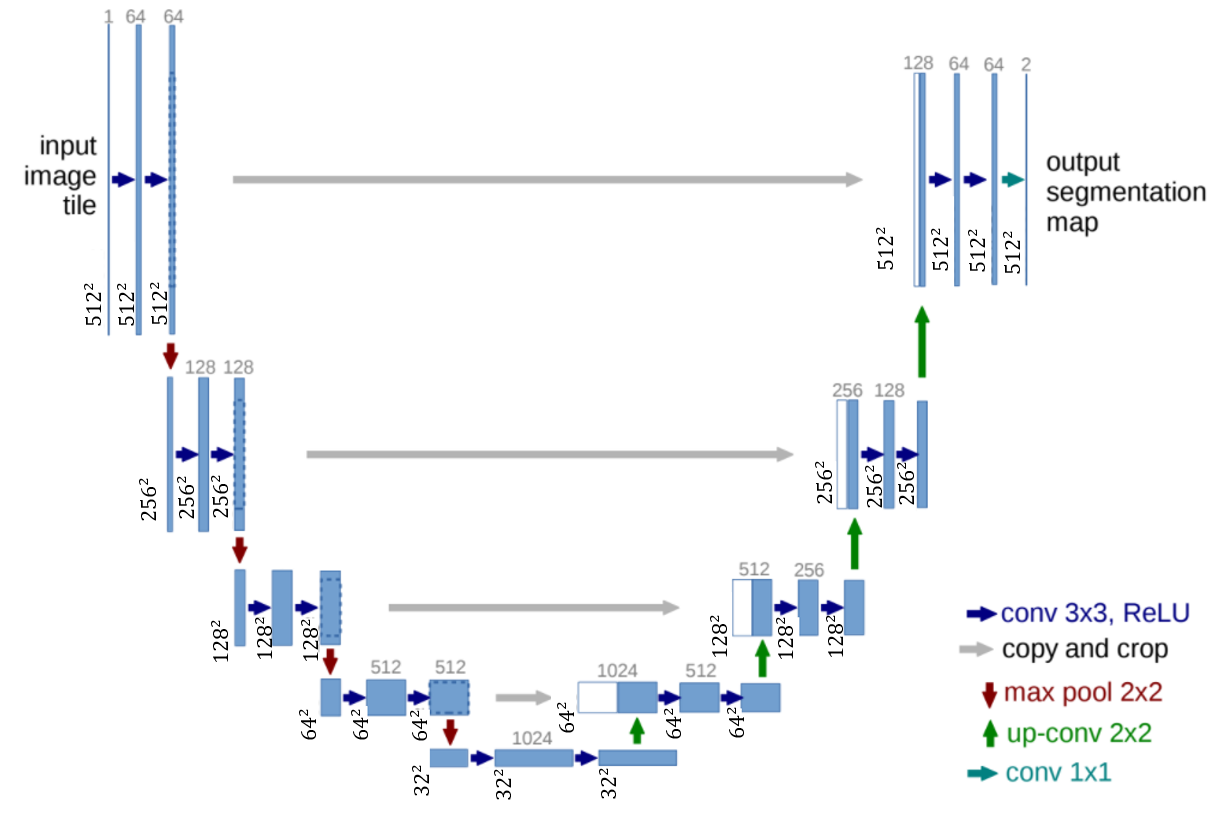

The following code blocks contain our U-net implementation in Pytorch

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [ ]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


### Loss Functions:



### **Dice Score**:
Let $X,Y \in \{0,1\}^{N\times M}$ represent 2 binary matrices.

We define Dice Score mathematically as followed:

$Dice\ Score(X,Y) = \frac{2 \cdot |X\cap Y|}{|X|+|Y|}$

We shall notice that we can't use this function as our loss function since it is not differentiable. Thus, we have to modify this definition such that it will preserve the "original" relationship between $X$, and $Y$, while it will be differentiable.
Therefore, we reshape $Y$ to be a flattened version of our ground truth mask and we replace $X$ with a flattened version of our network soft predication $\hat Y$. Let $Soft\ Dice\ Score(\hat Y,Y)$ be our new loss function.

$Soft\ Dice\ Score(\hat {Y},Y) = \frac{2 Y^T \hat {Y} }{||\hat{Y}||_1+||Y||_1}$

By using this scheme, we are able to drive our network towards a higher relative overlap between the prediction and the ground truth (intersection over union).
Because we are using the gradient descent method we define our Dice Score Loss (for a single data sample) as followed:

$L_{DSC}(\hat {Y},Y) = 1 - \frac{2 Y^T \hat {Y} }{||\hat{Y}||_1+||Y||_1}$

### **Binary Cross Entropy Loss**:
For a single data sample, the BCE loss defined as - 
$L_{BCE} = -\sum_{i=1}^{N\cdot M}\big(Y_i log(\hat{Y}_i) + (1-Y_i) log(1-\hat{Y}_i)\big)$ .

### **Combo Loss**
Our loss function is a combination of the familiar BCE loss function with the aforementioned Dice loss, i.e., $L_{Combo} = L_{DSC} + L_{BCE}$ The motivation behind using this "Combo loss" is described in [3].

In [ ]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]

def dice_loss(input: Tensor, target: Tensor):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    return 1 - dice_coeff(input, target, reduce_batch_first=True)

### Training Procedure
Our train function includes several steps:
1. Dynamic Preprocess
2. Run batch through the network
3. Calculate Loss and Backpropagate Gradients
4. Apply Optimizer Step to update our model's weights.
5. Every X batches we apply evaluation round where X = n_train // 2.

In [ ]:
def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        image, mask_true = batch['image'], batch['mask']
        # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32)
        mask_true = mask_true.to(device=device, dtype=torch.long)
        mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)

            # convert to one-hot format
            if net.n_classes == 1:
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += dice_loss(mask_pred[:, 1:, ...], mask_true[:, 1:, ...])

           

    net.train()

    # Fixes a potential division by zero error
    if num_val_batches == 0:
        return dice_score
    return dice_score / num_val_batches


In [ ]:
def train_net(net,
              device,
              train_set,
              val_set,
              epochs: int = 5,
              batch_size: int = 1,
              learning_rate: float = 0.00006,
              val_percent: float = 0.1,
              amp: bool = False):

    # 1. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=1, pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)
   
    print(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {len(train_loader)}
        Validation size: {len(val_loader)}
        Device:          {device.type}''')

    # 2. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss()
    global_step = 0

    # 3. Begin training
    for epoch in range(epochs):
        net.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images = batch['image']
                true_masks = batch['mask']

                assert images.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.cuda.amp.autocast(enabled=amp):
                    masks_pred = net(images)
                    loss = criterion(masks_pred, true_masks) \
                           + dice_loss(F.softmax(masks_pred, dim=1).float(), F.one_hot(true_masks, net.n_classes).permute(0, 3, 1, 2).float())

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (len(train_loader) // 2)
                if division_step > 0:
                    if global_step % division_step == 0:
                        val_score = evaluate(net, val_loader, device)
                        scheduler.step(val_score)
    return net

#### Ablation Study
The following diagram illustrates the influence of the hyper-parameters (learning rate, scheduler's patience, filter size) over the dice score.
To generate this diagram, we have used an out-source tool that conducts a sophisticated searching paradigm over the hyper-parameters space. The name of this tool is W&B (weights and biases). From these results we can conclude that the best Gaussian filter size is 5, the learning rate is 0.00006, and the patience is 5.
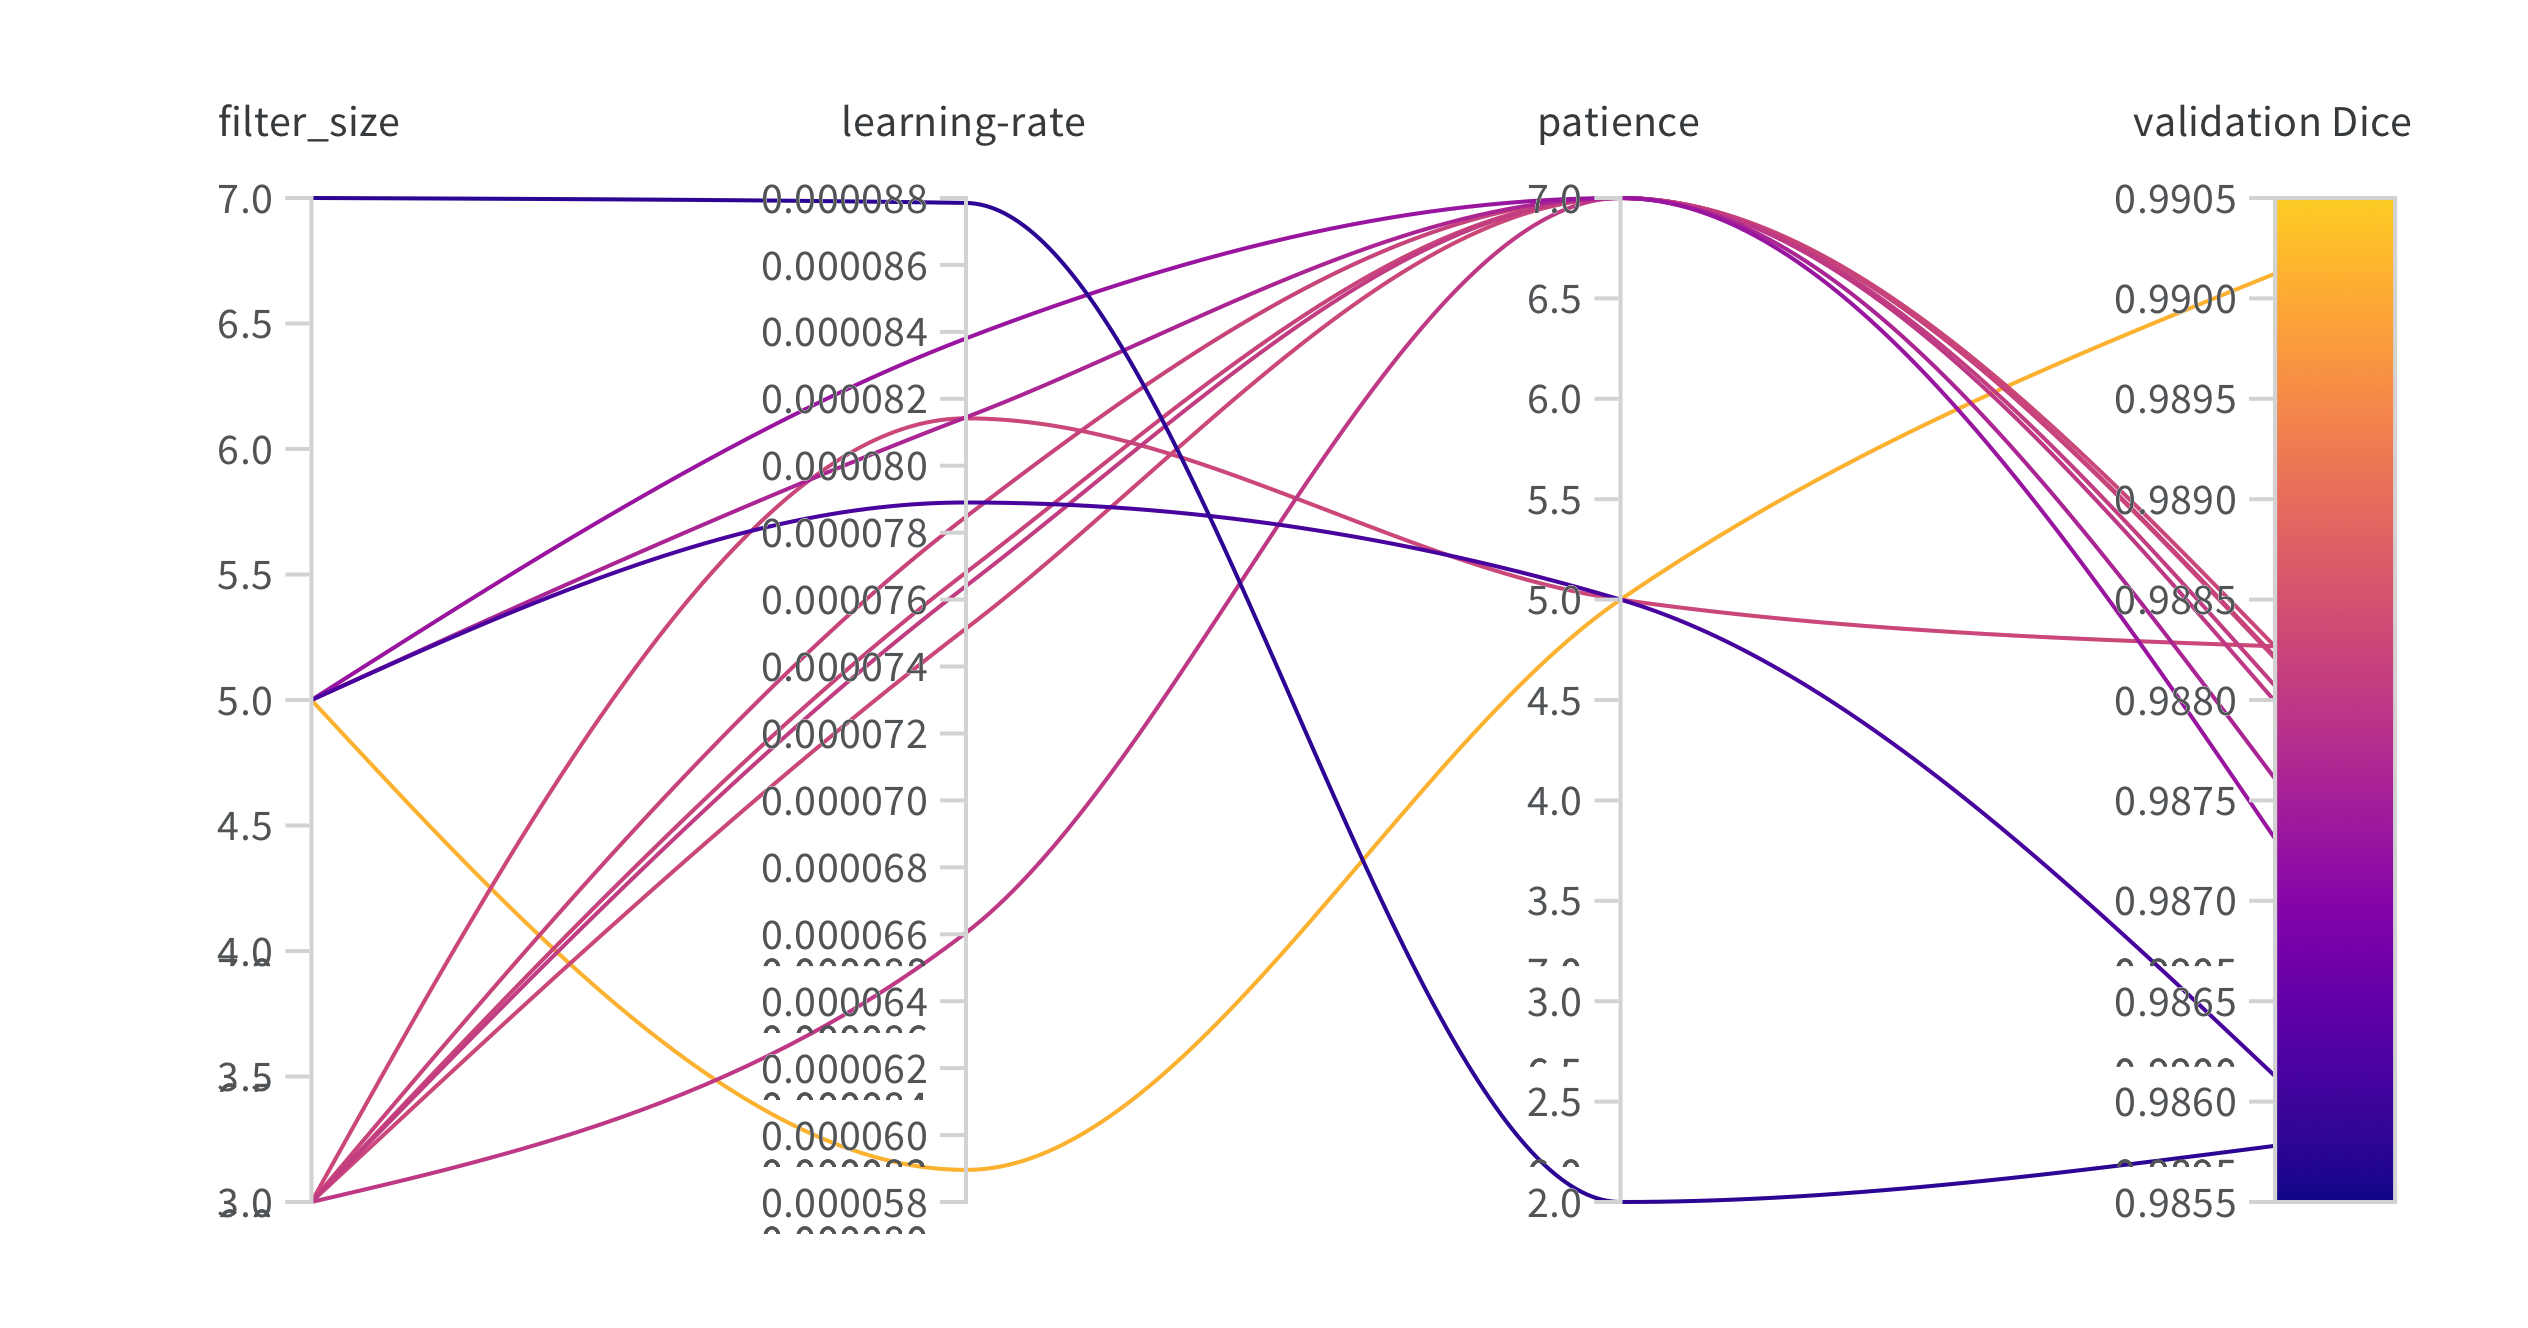

#### Train
For training the UNet we have used outsource GPU with the whole dataset

**Training via Colab is imposible because it throwing RAM error**

In [ ]:
# untrained_unet = UNet(3, 2).to(device)
# net = train_net(untrained_unet, device, mini_train_set, mini_train_set, epochs=40, batch_size=16)


As in the benchmark, we do not use a validation set. Hence, the following figure represent the train losses Learning Curves.
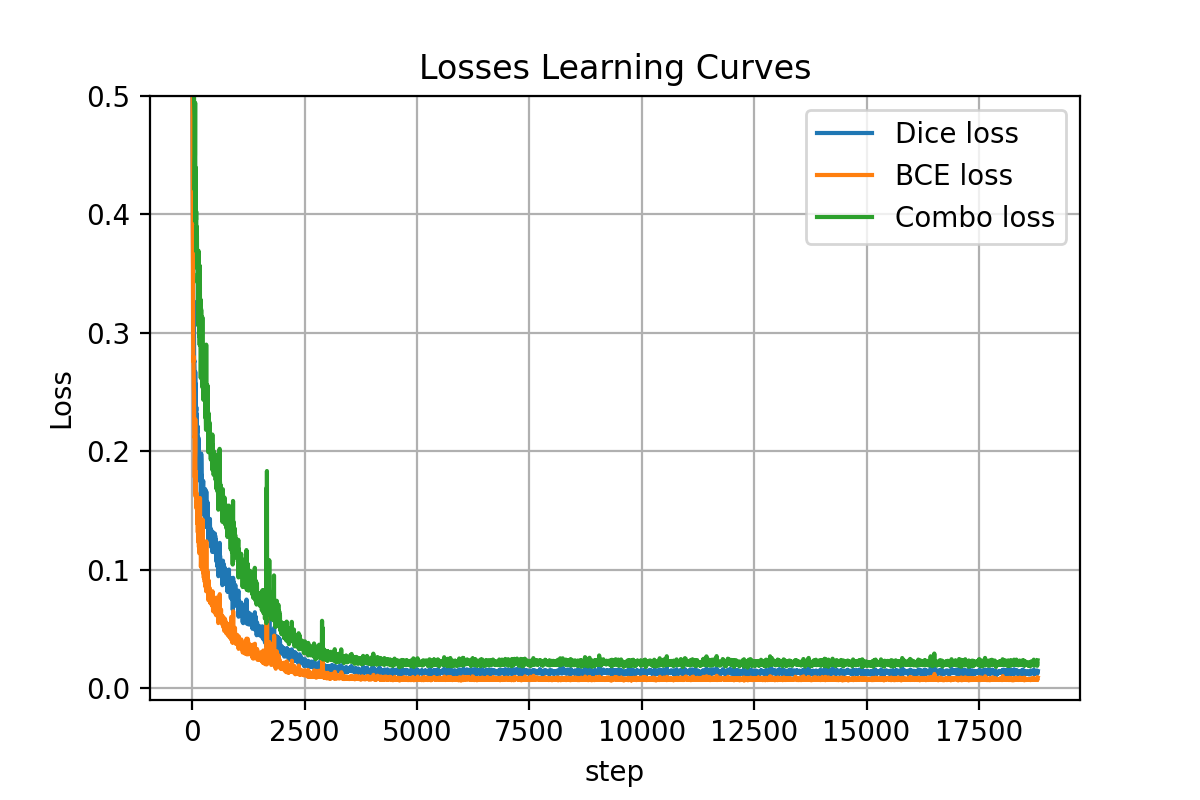

## Corners Coordinates Extraction

### Edge Detector

We implemented here a simple edge detector that runs over all pixels and removes the interior of the document shape from the masked image

In [ ]:
def edge(img):
    img_cpy = np.copy(img)
    x_size, y_size = img.shape
    for row in range(1, x_size-1):
        for col in range(1, y_size-1):
            if img[row, col] == 1:
                if (img[row+1, col] == 1) and (img[row-1, col] == 1) and (img[row, col+1] == 1) and (img[row, col-1] == 1):
                    img_cpy[row, col] = 0
    return img_cpy

def DerivativeEdges(img):
    derivative_img = edge(img)
    return derivative_img


### Hough Transform
The Standard Hough Transform (SHT) is a feature extraction technique used in image analysis, computer vision, and digital image processing. The purpose of the technique is to find imperfect instances of lines in an image. 

The Standard Hough Transform (SHT) uses the parametric representation of a line:

$\rho = x\cdot cos(\theta) + y\cdot sin(\theta)$.

The variable $\rho$ is the distance from the origin to the line along a vector perpendicular to the line. $\theta$ is the angle of the perpendicular projection from the origin to the line measured in degrees clockwise from the positive x-axis. The range of $\theta$ is $–90^{\circ} \leq \theta \leq 90^{\circ}$. 
The angle of the line itself is $\theta + 90^{\circ}$, also measured clockwise with respect to the positive x-axis.

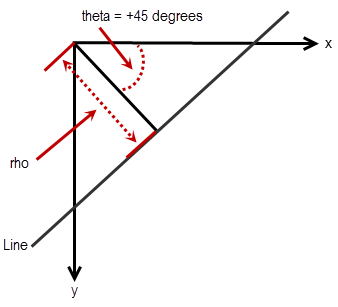

The SHT is a parameter space matrix whose rows and columns correspond to $\rho$ and $\theta$ values respectively. The elements in the SHT represent accumulator cells. Initially, the value in each cell is zero. Then, for every "True value" point in the binary image, $\rho$ is calculated for every $\theta$. $\rho$ is rounded off to the nearest allowed row in SHT. That accumulator cell is incremented. At the end of this procedure, a value of $z$ in SHT(r,c) means that $z$ points in the xy-plane lie on the line specified by $\theta[c]$ and $\rho[r]$. Peak values in the SHT represent potential lines in the input image.

In [ ]:
def CalculateHoughMatrix(edge_image, num_rhos=180, num_thetas=360):
    '''
    The input image shall be a logic image, i.e. only 0 and 1
    '''
    # Extract Image size
    edge_height, edge_width = edge_image.shape[:2]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    dtheta = 180 / num_thetas
    drho = (2 * d) / num_rhos
    thetas = np.arange(-90, 90, step=dtheta)
    rhos = np.arange(-d, d, step=drho)
    # Calculate Cosine and Sinus values of the axis
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    # Calculate the edge point indices from the edge image
    edge_points = np.argwhere(edge_image != 0)
    # Transform the axis to support negative rhos and thetas
    edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
    # Calculate the Rho Values in a Matrix formation
    rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))
    # Calculate the Hough Matrix
    accumulator = np.zeros((len(rhos), len(rhos)))
    accumulator, theta_vals, rho_vals = np.histogram2d(np.tile(thetas, rho_values.shape[0]), rho_values.ravel(), bins=[thetas, rhos])
    accumulator = np.transpose(accumulator)
    return accumulator, rhos, thetas

def CalculateHoughPeaks(H, numPeaks, threshold):
    done = False
    new_H = np.copy(H)
    peaks = []
    # Define neighborhood size
    nhood = np.array((H.shape[0] / 50, H.shape[1] / 50))
    nhood = [max(2 * np.ceil(elem / 2) + 1, 1) for elem in nhood]
    # Calculate neighborhood center
    nhood_center = [(elem-1)/2 for elem in nhood]
    THETA = 1
    RHO = 0
    while not done:
        # Extract the coordinates of rho and theta from the new Hough Matrix
        index = np.unravel_index(np.argmax(new_H), np.array(new_H).shape)
        max_val = new_H[index]
        # Check if this value sustain our predefined threshold for being an actual line in the original image
        if max_val > threshold:
            peaks.append(index)
            # Calculate the centers for both Rho and Theta from the chosen index
            theta_center, rho_center = index[THETA], index[RHO]
            # Calculate the neighborhood for both Rho and Theta from the chosen index around the current center
            theta_low_bound, rho_low_bound = theta_center - nhood_center[THETA], rho_center - nhood_center[RHO]
            theta_high_bound, rho_high_bound = theta_center + nhood_center[THETA], rho_center + nhood_center[RHO]
            
            # Generate a Grid of Rhos and Thetas Combination around the maximal point
            [rhos, thetas] = np.meshgrid(np.arange(np.max((0, rho_low_bound)), np.min((rho_high_bound, new_H.shape[RHO]))+1),
                                   np.arange(theta_low_bound, theta_high_bound + 1))
            '''
            The following Code just changes the values around the following peak to be 0 so we will not choose 
            any of them in the next round.
            '''
            rhos = rhos.ravel()
            thetas = thetas.ravel()

            theta_too_low = np.argwhere(thetas < 0)
            thetas[theta_too_low] = new_H.shape[1] + thetas[theta_too_low]
            rhos[theta_too_low] = new_H.shape[0] - rhos[theta_too_low]

            theta_too_high = np.argwhere(thetas >= new_H.shape[THETA])
            thetas[theta_too_high] = thetas[theta_too_high] - new_H.shape[THETA]
            rhos[theta_too_high] = new_H.shape[RHO] - rhos[theta_too_high]
            new_H[rhos.astype(np.int64), thetas.astype(np.int64)] = 0
            done = len(peaks) == numPeaks
        else:
            done = True
    return np.array(peaks)


### Proposed Hand-Crafted Clustring Method

Because the masked image is not a perfect quadrilateral, by taking the 4 peaks from the SHT matrix we often will not get the 4 lines that represent the quadrilateral. To solve this problem, we first pick 20 peaks from the SHT matrix. By doing this, there is a high probability that the 4 required lines are in the set of these 20 lines (each line represented by the pair $(\rho,\theta)$). The next step is to find these 4 lines. For that, we perform the Kmeans algorithm [4] over the $\theta$'s values of all the 20 lines; with $K=2$ and with $K=3$. We then calculate the Siloueght score [5] over each $K$ and check for which the maximal values are achieved. The Siloueght score is a measure of "how well" the clustering algorithm fits the data. The reason for doing this is that the masked shape is a kind of quadrilateral, hence among the 4 lines representing this shape, there are 2 pairs of "almost parallel" lines, therefore we expect to have 2 clusters when we cluster according to $\theta$. Because of that, if the maximal Silhouette score is achieved for $K=2$ we can be more confident that the 20 peaks represent lines that are close to the 4 true lines. Otherwise, if the maximal Silhouette score is achieved for $K=3$, then some of the predicted lines have to be discarded. In this case, we are discarding all the lines that belong to the cluster with the smaller number of points.
The next step is to apply 2D Kmeans (over both $\rho$, and $\theta$) with $K=4$  over all the reminded lines points (represented by  $(\rho,\theta)$). We then set the 4 centroids as the initial estimation of the 4 lines.


In [ ]:
def applyKmenas(thetas, rhos):
    sil = []
    kmax = 3
    expanded_theta = np.expand_dims(thetas, -1)
    for k in range(2, kmax + 1):
        kmeans = KMeans(n_init=20, random_state=1, max_iter=1000, tol=1e-6, n_clusters=k).fit(expanded_theta)
        labels = kmeans.labels_
        sil.append(silhouette_score(expanded_theta, labels))
    if np.argmax(sil) == 1:
        Centeroids = kmeans.cluster_centers_
        secondClusters = Centeroids
        ClusterMapping = kmeans.labels_
        args = np.argsort(Centeroids, axis=0)
        left_center = args[0]
        right_center = args[2]
        num_left = sum(ClusterMapping == left_center)
        num_right = sum(ClusterMapping == right_center)
        if num_left < num_right:
            thetas = thetas[ClusterMapping != left_center]
            rhos = rhos[ClusterMapping != left_center]
        else:
            thetas = thetas[ClusterMapping != right_center]
            rhos = rhos[ClusterMapping != right_center]

    clusterSize = 4
    kmeans = KMeans(n_clusters=clusterSize).fit(np.column_stack((thetas, rhos)))
    Centeroids = kmeans.cluster_centers_
    args = np.argsort(np.abs(Centeroids[:, 0]), axis=0)
    peaks = Centeroids[args, :]
    return peaks


### Estimate Corners via Line Intersections
Now, when we have the 4 estimated lines in polar representation, we convert them to the standard representation ($y=mx+b$) and analytically calculates the intersections between each pair of relevant lines. A relevant lines pair is a pair of lines that are not "almost parallel". We can easily identify them from the clustering over $\theta$ from the previous step.



In [ ]:
def FindIntersectionsInXYRepresentation(peaks):
    def find_x(rhos, thetas):
        assert len(rhos) == 2
        assert len(thetas) == 2
        rad_thetas = np.deg2rad(thetas)
        denom = np.zeros((2,1))
        numerator = np.zeros((2, 1))
        for idx, data in enumerate(zip(rhos, rad_thetas)):
            rho, theta = data
            denom[idx] = np.cos(theta) / np.sin(theta)
            numerator[idx] = rho / np.sin(theta)
        '''
        Calculate the following equation
        X = (rho0 / sin(theta0) - rho1 / sin(theta1)) / (cos(theta0) / sin(theta0) - cos(theta1) / sin(theta1))
        '''
        x = (numerator[0] - numerator[1]) / (denom[0] - denom[1])
        return x

    def find_y(rho, theta, x):
        rad_theta = np.deg2rad(theta)
        '''
        Calculate the following equation
        Y = rho/sin(theta)-x*cos(theta)/sin(theta);
        '''
        y = rho/np.sin(rad_theta) - x*np.cos(rad_theta)/np.sin(rad_theta)
        return y

    assert peaks.shape[0] == 4
    X = 0
    Y = 1
    THETA = 0
    RHO = 1
    corners_estimation = np.zeros_like(peaks)
    # Sort according to theta
    sorted_args = np.argsort(peaks[:, THETA], axis=0)
    sorted_peaks = peaks[sorted_args]
    sorted_peaks[np.abs(sorted_peaks[:, THETA]) < 0.001, THETA] = 0.001
    # Generate intersection pairs in a list formation
    [THETAS, RHOS] = np.meshgrid(range(0, 2), range(2, 4))
    peaks_pairs = [(sorted_peaks[i], sorted_peaks[j]) for i, j in zip(THETAS.ravel(), RHOS.ravel())]
    for corner_idx, pair in enumerate(peaks_pairs):
        thetas = []
        rhos = []
        thetas.extend([peak[THETA] for peak in pair])
        rhos.extend([peak[RHO] for peak in pair])
        corners_estimation[corner_idx][X] = find_x(rhos, thetas)
        corners_estimation[corner_idx][Y] = find_y(rho=pair[0][RHO], theta=pair[0][THETA], x=corners_estimation[corner_idx][X])
    return corners_estimation


## Corners Estimation Refiner
To further improve the corners estimation, for each corner, we check for the closest point to this corner among all the edges points in the edged masked image. This way, we can get closer to the true corner estimation because we know that this is should be near the edges of the masked image.

In [ ]:
def closest_point(edge_img, corners):
    # Find the indices where the edge appears in the mask
    doc_edges_indices = np.where(edge_img == 1)
    # Transform it to matrix representation
    doc_edges_indices = np.array(list(doc_edges_indices)).T
    # Find the distances in x axis
    x_dist = np.square((np.expand_dims(corners[:, 0], axis=1) - np.expand_dims(doc_edges_indices[:, 0], axis=0)))
    # Find the distances in y axis
    y_dist = np.square((np.expand_dims(corners[:, 1], axis=1) - np.expand_dims(doc_edges_indices[:, 1], axis=0)))
    # Find the approximated distance ~ we dont use square root and mean in order to accelerate  
    distance_vec = x_dist + y_dist
    # Find the minimum distance indices
    idx = np.argmin(distance_vec, axis=1)
    # Fine tune the corner estimation
    closest_point = doc_edges_indices[idx]
    return closest_point


##Results

Loading the trained UNet weights

In [ ]:
w_path = "/content/drive/MyDrive/DeepLearningProject/Checkpoints/Hough_UNet/Unet512x512_checkpoint_filter_5x5.pth"
pretrained_unet = UNet(3, 2)
pretrained_unet.load_state_dict(torch.load(w_path, map_location=torch.device('cpu')))

<All keys matched successfully>

###Flow Visualization

In [ ]:
def plot_hough(H, estimated_peaks, hough_peaks, T, R):
    """
    This function prints the Hough Matrix
    """
    fig, ax = plt.subplots(1, 1)
    ax.imshow(np.log1p(H))
    ax.scatter(hough_peaks[:, 1], hough_peaks[:, 0], c='red', label="Hough peaks")
    newThetaAxis = (np.digitize(estimated_peaks[:, 0], T)) 
    newRhoAxis = np.digitize(estimated_peaks[:, 1], R)
    ax.scatter(newThetaAxis, newRhoAxis, c='yellow', label="Estimated lines")
    ax.set_title("Hough Matrix")
    plt.xticks(list(range(0,360,20)),list(range(-90,90,10)))
    plt.yticks(list(range(0,180,10)),list(range(-90,90,10)))
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\rho$')
    plt.legend()
    plt.show()
    

In [ ]:
def plot_img_and_mask(img, mask, corners):
    """
    This function prints an img,  its ground truth mask, and also prints a given corners indices over them
    """
    classes = mask.shape[0] if len(mask.shape) > 2 else 1
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title('Input image')
    ax[0].imshow(img)
    ax[0].scatter(corners[:, 0], corners[:, 1], c='red')
    if classes > 1:
        for i in range(classes):
            ax[i + 1].set_title(f'Output mask (class {i + 1})')
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].scatter(corners[:, 0], corners[:, 1], c='red')
    else:
        ax[1].set_title(f'Ground Truth Mask')
        ax[1].imshow(mask)
        ax[1].scatter(corners[:, 0], corners[:, 1], c='red')
    plt.xticks([]), plt.yticks([])
    plt.show()

#### Predicted Mask via UNet

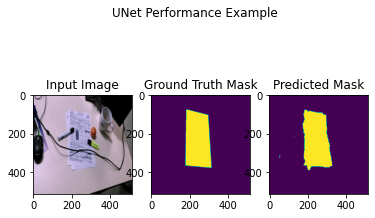

In [ ]:
data_example = test_set_bg_5[3]
# precalculated mean and std over the full train set
train_mean = 151.84097687205238 
train_std = 43.61468699572161
img = data_example['image']
gt_mask = data_example['mask'].T
norm_img = (img - train_mean) / train_std
gt_coords = list(data_example['label'].numpy())
pred_mask = pretrained_unet(norm_img.unsqueeze(dim=0).to(device)).detach()
pred_mask = F.one_hot(pred_mask.argmax(dim=1), pretrained_unet.n_classes).permute(0, 3, 1, 2).float().numpy()[0,1,:,:].T
fig, ax = plt.subplots(1, 3)
fig.suptitle('UNet Performance Example')
ax[0].set_title('Input Image')
ax[0].imshow(img.transpose(0,-1).int())
ax[1].set_title('Ground Truth Mask')
ax[1].imshow(gt_mask)
ax[2].set_title('Predicted Mask')
ax[2].imshow(pred_mask)

#### Extract Edges

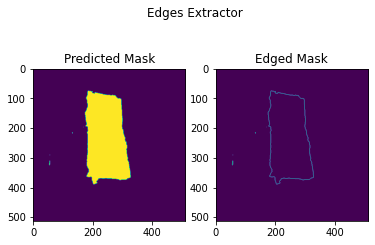

In [ ]:
edge_img = DerivativeEdges(pred_mask)
fig, ax = plt.subplots(1, 2)
fig.suptitle('Edges Extractor')
ax[0].set_title('Predicted Mask')
ax[0].imshow(pred_mask)
ax[1].set_title('Edged Mask')
ax[1].imshow(edge_img)


#### Hough Matrix Visualisiation with 20 Peaks and The 4 Predicted Estimated Lines

In [ ]:
def e2e_algorithm(img, numPeaks=20):
    # End to End Corner Extraction from the masked image
    edge_image = DerivativeEdges(img)
    H, R, T = CalculateHoughMatrix(edge_image)
    hough_peaks = CalculateHoughPeaks(H, numPeaks, threshold=0.1 * np.max(H))
    thetas = T[hough_peaks[:, 1]]
    rhos = R[hough_peaks[:, 0]]
    estimated_peaks = applyKmenas(thetas, rhos)
    corners_estimation = FindIntersectionsInXYRepresentation(estimated_peaks)
    corners_estimation[:, 0] += img.shape[1]/2
    corners_estimation[:, 1] += img.shape[0]/2
    corners_estimation_closest_point = np.fliplr(closest_point(edge_image, np.fliplr(corners_estimation)))
    return corners_estimation_closest_point, corners_estimation, H, T, R, hough_peaks, estimated_peaks


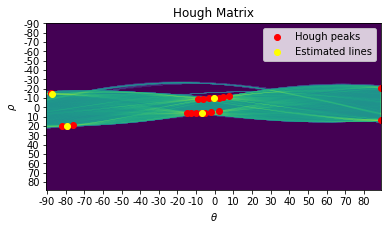

In [ ]:
corners_estimation_closest_point, corners_estimation, H, T, R, hough_peaks, estimated_peaks = e2e_algorithm(pred_mask, numPeaks=20)
plot_hough(H, estimated_peaks, hough_peaks, T, R)

#### Corners Prediction

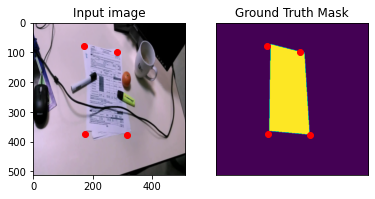

In [ ]:
plot_img_and_mask(img.transpose(0,-1).int(), gt_mask, corners_estimation)

#### Corners Prediction after closest point correction

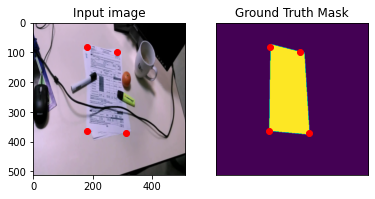

In [ ]:
plot_img_and_mask(img.transpose(0,-1).int(), gt_mask, corners_estimation_closest_point)

### Evaluate Dice Score over the test set



In [ ]:
def evaluate_e2e_algorithm(dataset, batch_size, net):
    loader_args = dict(batch_size=batch_size, pin_memory=True)
    loader = DataLoader(dataset, shuffle=True, drop_last=True, **loader_args)
    cnt = 0
    dice_score = []
    for batch in loader:
        images = batch['image']
        true_masks = batch['mask']
        images = images.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device, dtype=torch.long)
        with torch.no_grad():
            masks_pred = net(images)
        predSegment = masks_pred[:, 1, ...]
        predSegment[predSegment < 0.5] = 0
        predSegment[predSegment >= 0.5] = 1
        temp_dice_score = []
        for idx in range(batch_size):
            curr_cleaned_mask = predSegment[idx].detach().cpu().numpy()
            masks_pred = e2e_algorithm(curr_cleaned_mask)[0]
            mask_predicated = gen_mask(masks_pred, sizeX=true_masks[idx].shape[0], sizeY=true_masks[idx].shape[1], sort=True)
            score = dice_coeff(torch.tensor(mask_predicated, dtype=torch.float).to(device), true_masks[idx].type(torch.float))
            # print(score.item())
            temp_dice_score.append(score.item())
        # print(f'Batch-{cnt} - Dice Score = {np.mean(temp_dice_score)}')
        dice_score.extend(temp_dice_score)
        cnt += 1
    # print(f'Total Dice Score Background {bg} = {np.mean(dice_score)}')
    return np.array(dice_score)


Running the following code over the whole test set can take a lot of time. Therefore we ran this offline and report the results:

*   Background01 Average Dice Score - 0.9553858727216721
*   Background02 Average Dice Score - 0.9310153740617327
*   Background03 Average Dice Score - 0.9566100876219571
*   Background04 Average Dice Score - 0.9649384463351706
*   Background05 Average Dice Score - 0.87300871776446 



In [ ]:
# pretrained_unet = pretrained_unet.to(device)

# plt.figure()
# res = []
# for idx in range(1,6):
#     curr_dsc = evaluate_e2e_algorithm(eval(f'test_set_bg_{idx}'), 5, pretrained_unet)
#     print(f'bg_{idx}_DSC_Mean = {np.mean(curr_dsc)}')
#     res.append(curr_dsc)
# plt.boxplot(res, positions=[2, 4, 6, 8, 10], showfliers=False)
# plt.grid()
# plt.xticks([2, 4, 6, 8, 10], ['BG 1', 'BG 2', 'BG 3', 'BG 4', 'BG 5'], rotation=20)
# plt.show()

#### Box Plot of Dice Score per Background
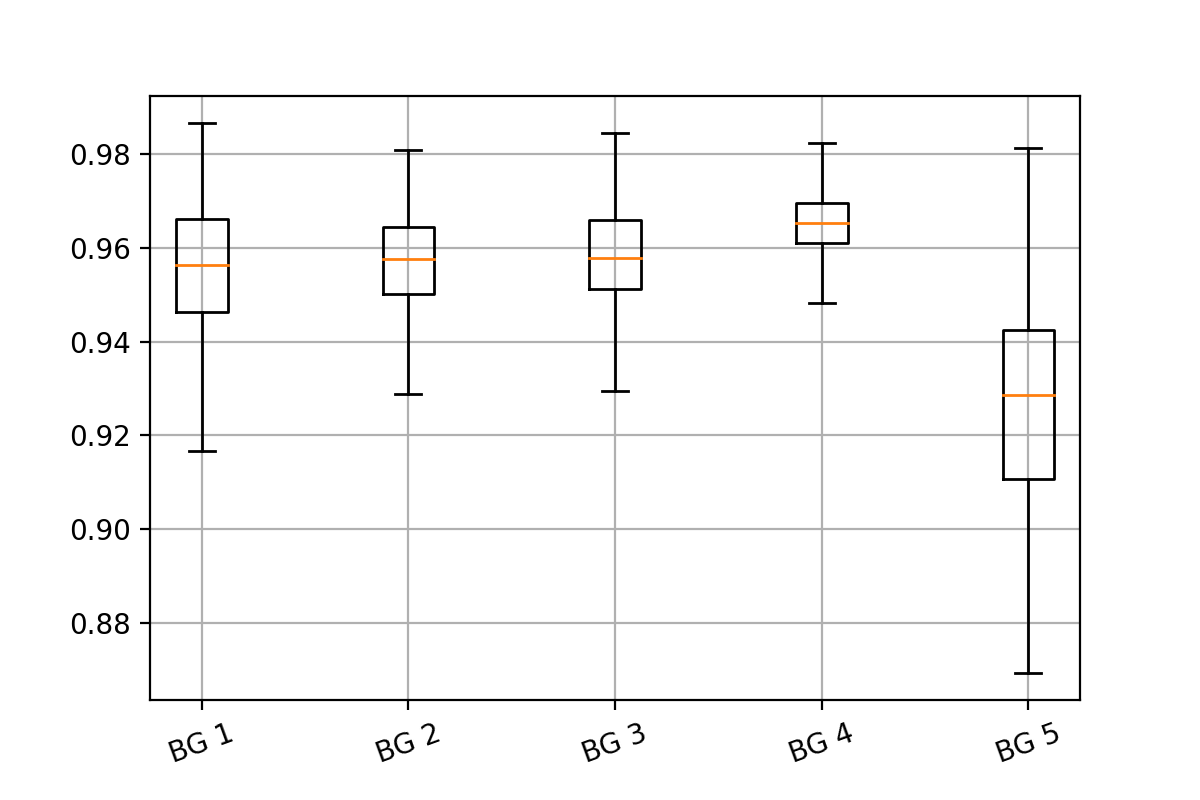


### Algorithm Results Analysis
A few insights from the development of this algorithm

1. It is important to mention that during train and inference we used an images of size 512X512 as opposed to the original images size(that used in the benchmark algorithm and the second proposed algorithm). 
2. Rescaling the predicted corners coordinates to the original images size (1920X1080), induces further error in the estimation. Therefore this algorithm is limited in the sense that we have to use the size of the original images when we feed them to the UNet in order to predict the corresponded corners without an additional estimation error which can be very large. 
3. For image sizes larger than 512X512, the computations become costly. 
4. At the beginning we were able to segment the images properly only when the size of the images was 64X64. When the predicted labels are rescaled to estimate the corners in the 512X512 images this algorithm suffered from a severe error. 
5. To solve this problem, we used 512X512 input images for training. The segmentation results got worst because these images contained more details compared to the smaller images and therefore the UNet captures undesired elements from the images. This lead us to apply a Gaussian filter as part of the Preprocess to make the images blurrier. This allowed us to use the UNet with larger images.








# References


[1] Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.‏

[2] Richard O. Duda and Peter E. Hart. 1972. Use of the Hough transformation to detect lines and curves in pictures. Commun. ACM 15, 1 (Jan. 1972), 11–15. 

[3] Taghanaki, Saeid Asgari, et al. "Combo loss: Handling input and output imbalance in multi-organ segmentation." Computerized Medical Imaging and Graphics 75 (2019): 24-33.

[4] Forgy, Edward W. (1965). "Cluster analysis of multivariate data: efficiency versus interpretability of classifications". Biometrics. 21 (3): 768–769.

[5] Peter J. Rousseeuw (1987). "Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis". Computational and Applied Mathematics. 20: 53–65

